In [40]:
# inline plotting
%matplotlib inline

# allow live package editing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Importing the OpenDSM library

Once the OpenDSM has been installed, it can be imported as shown below.

This tutorial requires OpenDSM version > 1.2.x. Verify the version you have installed.

We will load eemeter and drmeter modules separately

In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import opendsm as odsm
from opendsm import (
    eemeter as em,
    drmeter as dm,
)

print(f"OpenDSM {odsm.__version__}")

OpenDSM 1.2.6


## Loading data

The essential inputs to OpenDSM library functions are the following:

1. Meter baseline data named `observed`
2. Meter reporting data `observed`
3. Temperature data from a nearby weather station for both named `temperature`
4. All data is expected to have a timezone-aware datetime index or column named `datetime`

Users of the library are responsible for obtaining and formatting this data (to get weather data, see [eeweather](https://eeweather.openee.io/), which helps perform site to weather station matching and can pull and cache temperature data directly from public (US) data sources). Some samples come loaded with the library and we'll load these first to save you the trouble of loading in your own data.

We utilize data classes to store meter data, perform transforms, and validate the data to ensure data compliance. The inputs into these data classes can either be [pandas](https://pandas.pydata.org/) `DataFrame` if initializing the classes directly or `Series` if initializing the classes using `.from_series`.

The test data contained within the OpenDSM library is derived from [NREL ComStock](https://comstock.nrel.gov/) simulations.

If working with your own data instead of these samples, please refer directly to the excellent pandas documentation for instructions for loading data (e.g., [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)).

### Important notes about data:
- *These models were developed and tested using Fahrenheit temperature. Please convert your temperatures accordingly*
- *It is expected that all data is trimmed to its appropriate time period (baseline and reporting) and does not contain extraneous datetimes*
- *If you run load_test_data it will download the necessary files from the OpenDSM repository. This can be up to 150 MB*

In [42]:
# Load in test data
#     - This data contains 100 different meters

df_baseline, df_reporting = odsm.test_data.load_test_data("monthly_treatment_data")

In [43]:
print(df_baseline)

                                  temperature       observed
id     datetime                                             
108618 2018-01-01 00:00:00-06:00    -2.384038  257406.539278
       2018-01-02 00:00:00-06:00     1.730000            NaN
       2018-01-03 00:00:00-06:00    13.087946            NaN
       2018-01-04 00:00:00-06:00     4.743269            NaN
       2018-01-05 00:00:00-06:00     4.130577            NaN
...                                       ...            ...
120841 2018-12-27 00:00:00-06:00    52.010625            NaN
       2018-12-28 00:00:00-06:00    35.270000            NaN
       2018-12-29 00:00:00-06:00    29.630000            NaN
       2018-12-30 00:00:00-06:00    34.250000            NaN
       2018-12-31 00:00:00-06:00    43.311250            NaN

[36500 rows x 2 columns]


## BILLING EXAMPLE

Let's repeat this to show how the billing model works almost the same

Note that the only difference in how these are called are the specific data classes and model used. Everything else remains the same.

- As with the Daily data, Billing data should have hourly temperature
- Billing data is reversed from a customer perspective. From a customer perspective, you pay for the month you used energy and so the bill is for the month prior. To model this, the start date should have the usage for a given month

In [44]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

baseline_data = em.BillingBaselineData(df_baseline_n, is_electricity_data=True)
reporting_data = em.BillingReportingData(df_reporting_n, is_electricity_data=True)

billing_model = em.BillingModel().fit(baseline_data, ignore_disqualification=False)
billing_model.predict(baseline_data).head()

,season,day_of_week,weekday_weekend,temperature,observed,predicted,predicted_unc,heating_load,cooling_load,model_split,model_type
datetime,,,,,,,,,,,
2018-01-01 00:00:00-06:00,winter,1,weekday,-10.0450,4629.919385,4688.669772,865.261233,2390.857575,0.0,fw-su_sh_wi,hdd_tidd
2018-01-02 00:00:00-06:00,winter,2,weekday,-4.7125,4629.919385,4524.738288,865.261233,2226.926092,0.0,fw-su_sh_wi,hdd_tidd
2018-01-03 00:00:00-06:00,winter,3,weekday,11.3525,4629.919385,4030.868756,865.261233,1733.056559,0.0,fw-su_sh_wi,hdd_tidd
2018-01-04 00:00:00-06:00,winter,4,weekday,0.9725,4629.919385,4349.970265,865.261233,2052.158068,0.0,fw-su_sh_wi,hdd_tidd
2018-01-05 00:00:00-06:00,winter,5,weekday,3.1475,4629.919385,4283.106510,865.261233,1985.294313,0.0,fw-su_sh_wi,hdd_tidd


In [45]:
print(df_baseline_n)

                           temperature       observed
datetime                                             
2018-01-01 00:00:00-06:00   -10.045000  143527.500929
2018-01-02 00:00:00-06:00    -4.712500            NaN
2018-01-03 00:00:00-06:00    11.352500            NaN
2018-01-04 00:00:00-06:00     0.972500            NaN
2018-01-05 00:00:00-06:00     3.147500            NaN
...                                ...            ...
2018-12-27 00:00:00-06:00    46.760000            NaN
2018-12-28 00:00:00-06:00    35.323125            NaN
2018-12-29 00:00:00-06:00    26.386250            NaN
2018-12-30 00:00:00-06:00    28.463750            NaN
2018-12-31 00:00:00-06:00    40.345250            NaN

[365 rows x 2 columns]


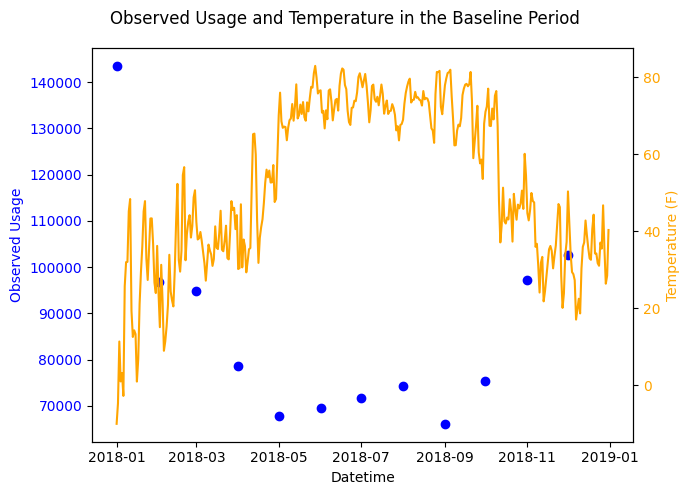

In [46]:
fig, ax1 = plt.subplots(figsize=(7, 5))

color = 'blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Observed Usage', color=color)
ax1.plot(df_baseline_n.index, df_baseline_n['observed'], label='Observed Usage', color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'orange'
ax2.set_ylabel('Temperature (F)', color=color)
ax2.plot(df_baseline_n.index, df_baseline_n['temperature'], label='Temperature (F)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Observed Usage and Temperature in the Baseline Period')
fig.tight_layout()
plt.show()

In [47]:
print(baseline_data.df)

                           season weekday_weekend  temperature     observed
datetime                                                                   
2018-01-01 00:00:00-06:00  winter         weekday   -10.045000  4629.919385
2018-01-02 00:00:00-06:00  winter         weekday    -4.712500  4629.919385
2018-01-03 00:00:00-06:00  winter         weekday    11.352500  4629.919385
2018-01-04 00:00:00-06:00  winter         weekday     0.972500  4629.919385
2018-01-05 00:00:00-06:00  winter         weekday     3.147500  4629.919385
...                           ...             ...          ...          ...
2018-12-27 00:00:00-06:00  winter         weekday    46.760000  3312.268813
2018-12-28 00:00:00-06:00  winter         weekday    35.323125  3312.268813
2018-12-29 00:00:00-06:00  winter         weekend    26.386250  3312.268813
2018-12-30 00:00:00-06:00  winter         weekend    28.463750  3312.268813
2018-12-31 00:00:00-06:00  winter         weekday    40.345250  3312.268813

[365 rows x

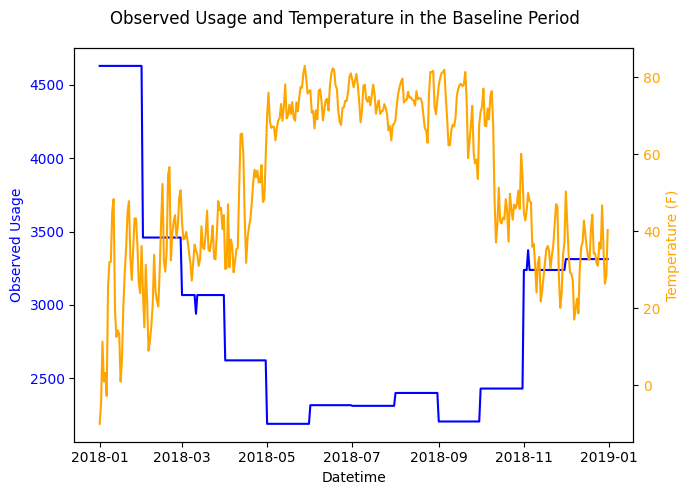

In [48]:
fig, ax1 = plt.subplots(figsize=(7, 5))

color = 'blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Observed Usage', color=color)
ax1.plot(baseline_data.df.index, baseline_data.df['observed'], label='Observed Usage', color=color, linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'orange'
ax2.set_ylabel('Temperature (F)', color=color)
ax2.plot(baseline_data.df.index, baseline_data.df['temperature'], label='Temperature (F)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Observed Usage and Temperature in the Baseline Period')
fig.tight_layout()
plt.show()

In [49]:
# baseline_data = em.BillingBaselineData.from_series(df_baseline_n['observed'], df_baseline_n['temperature'], is_electricity_data=True)

In [50]:
print(f"Disqualifications: {baseline_data.disqualification}")
print(f"Warnings:          {baseline_data.warnings}")

Disqualifications: []
Warnings:          [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.unable_to_confirm_daily_temperature_sufficiency)]


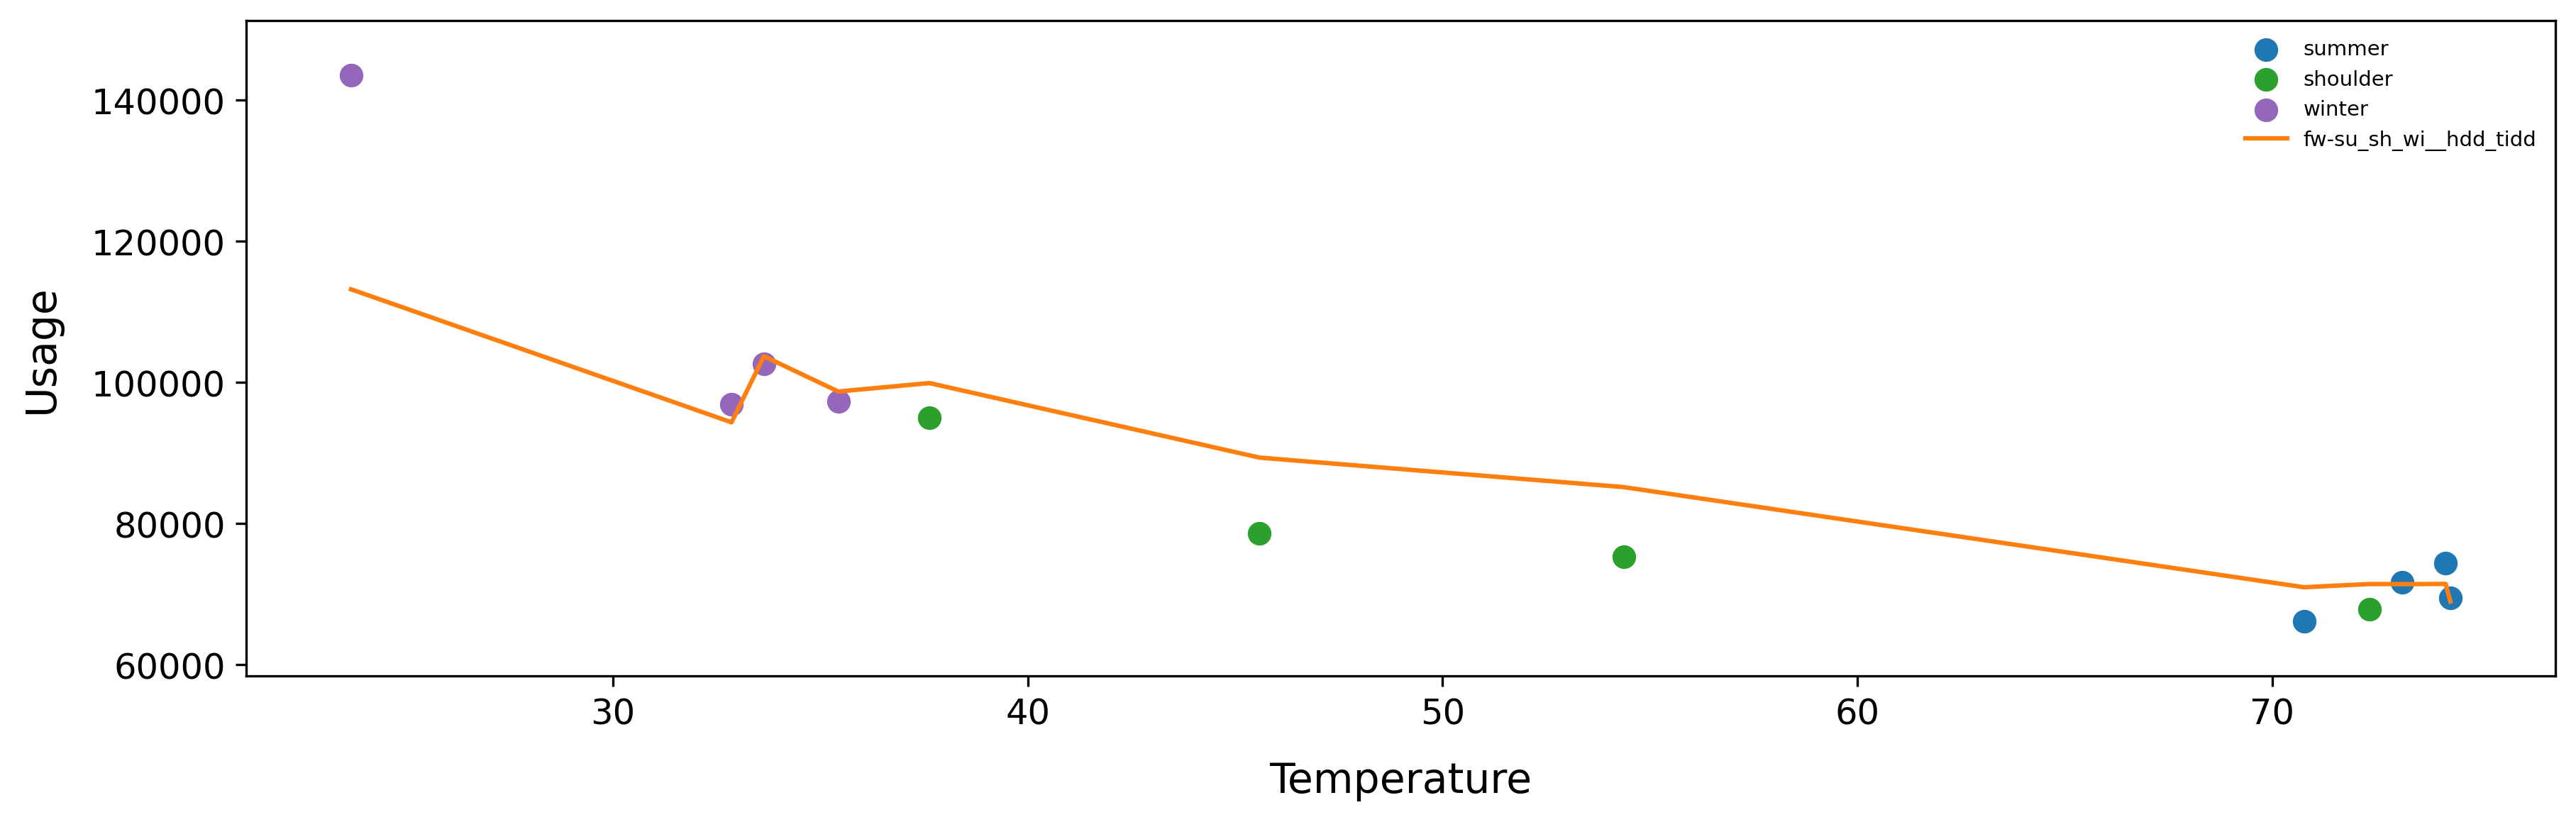

In [52]:
billing_model.plot(baseline_data, aggregation="monthly")

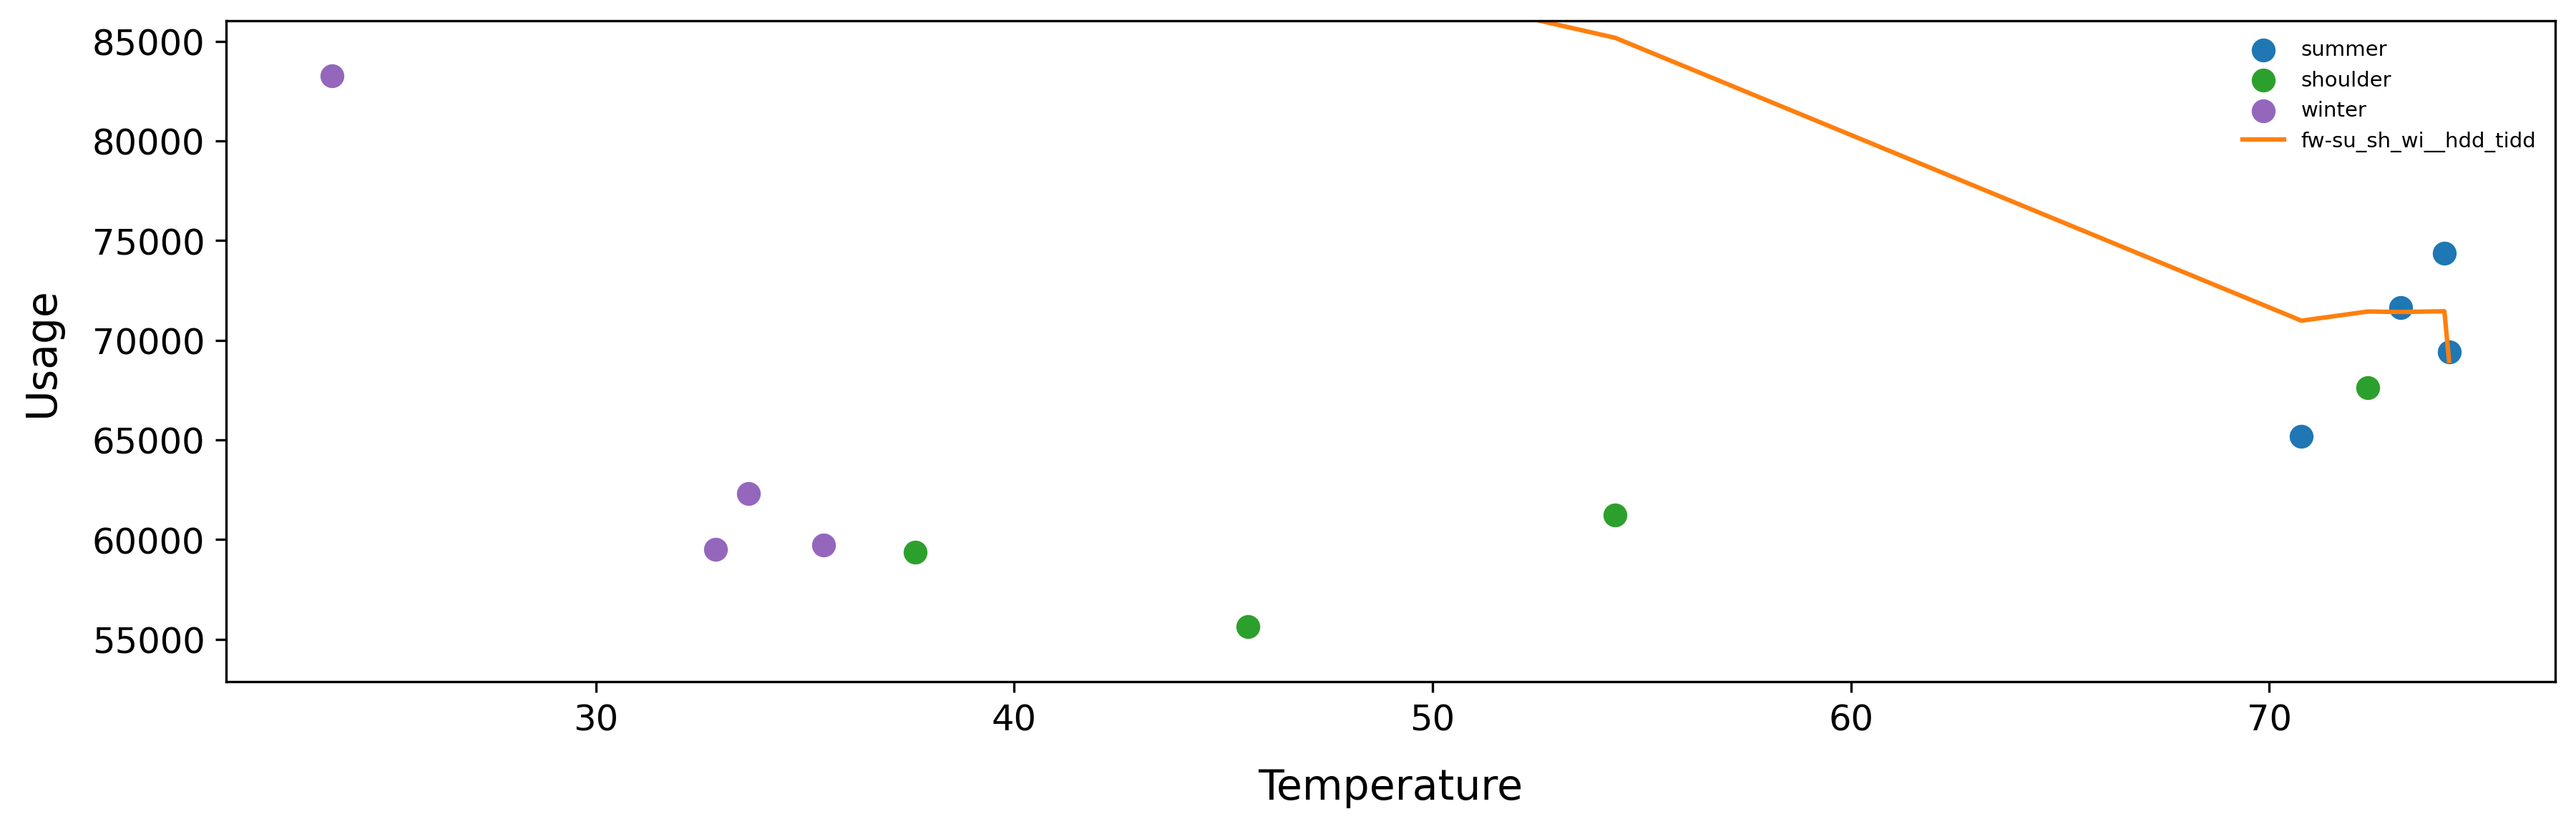

In [55]:
billing_model.plot(reporting_data, aggregation="monthly")

The billing model prediction function does have additional functionality built into it where it can aggregate from averaged daily data to `monthly` or `bimonthly`

In [56]:
df_results = billing_model.predict(reporting_data, aggregation="monthly")
print(df_results.head())

                             season  temperature      observed      predicted  \
datetime                                                                        
2019-01-01 00:00:00-06:00    winter    23.684855  83259.561689  113204.189203   
2019-02-01 00:00:00-06:00    winter    32.858562  59500.977283   94352.449401   
2019-03-01 00:00:00-06:00  shoulder    37.632207  59374.674004   99912.353102   
2019-04-01 00:00:00-05:00  shoulder    45.590826  55628.416668   89349.469105   
2019-05-01 00:00:00-05:00  shoulder    72.356294  67624.123278   71439.541663   

                           predicted_unc  heating_load  cooling_load  \
datetime                                                               
2019-01-01 00:00:00-06:00    4817.570659  41972.011102           0.0   
2019-02-01 00:00:00-06:00    4578.532084  30013.707891           0.0   
2019-03-01 00:00:00-06:00    4817.570659  28680.175001           0.0   
2019-04-01 00:00:00-05:00    4739.230955  20415.103201           0.0   


In [58]:
df_results['savings'] = df_results['predicted'] - df_results['observed']
print(f"Predicted Usage (kWh):  {round(df_results['predicted'].sum(), 2)}")
print(f"Observed Usage (kWh):   {round(df_results['observed'].sum(), 2)}")
print(f"Savings (kWh):          {round(df_results['savings'].sum(), 2)}")

Predicted Usage (kWh):  1038677.49
Observed Usage (kWh):   789252.05
Savings (kWh):          249425.45


In [59]:
saved_model = billing_model.to_json()
print(saved_model)

{"submodels": {"fw-su_sh_wi": {"coefficients": {"model_type": "hdd_tidd", "intercept": 2297.8121967963853, "hdd_bp": 67.72680897508171, "hdd_beta": -30.741956585408087, "hdd_k": null, "cdd_bp": null, "cdd_beta": null, "cdd_k": null}, "temperature_constraints": {"T_min": -10.045, "T_max": 83.00500000000001, "T_min_seg": 12.545, "T_max_seg": 81.155}, "f_unc": 865.2612331776701}}, "info": {"metrics": {"num_model_params": 3, "wrmse": 419.24394756674826, "n": 365, "n_prime": 27.66964273507515, "ddof": 362, "ddof_autocorr": 24.66964273507515, "observed": {"sum": 1038753.1599362098, "mean": 2845.899068318383, "variance": 488312.02991311357, "std": 698.7932669345875, "cvstd": 0.24554393889573123, "sum_squared": 3134420540.9935226, "median": 2429.3228342442544, "MAD_scaled": 333.1117536358844, "iqr": 926.6745388691215, "skew": 1.2625298968979632, "kurtosis": 0.9156722074740755}, "predicted": {"sum": 1038737.259890548, "mean": 2845.8555065494465, "variance": 312476.71880654804, "std": 558.996170

In [60]:
loaded_model = em.BillingModel.from_json(saved_model)

In [69]:
# set rows 1:38 of observed to nan
df_baseline_n_dq = df_baseline_n.copy()
df_baseline_n_dq.loc[df_baseline_n_dq.index[1:38], "observed"] = np.nan

baseline_data_DQ = em.BillingBaselineData(df_baseline_n_dq, is_electricity_data=True)
print(f"Disqualifications: {baseline_data_DQ.disqualification}")

['2018-01-01T00:00:00-06:00']
{'n_days_total': 306}


Disqualifications: [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.offcycle_reads_in_billing_monthly_data), EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.incorrect_number_of_total_days)]


In [70]:
try:
    billing_model = em.BillingModel().fit(baseline_data_DQ)
except Exception as e:
    print(f"Exception: {e}")

['2018-01-01T00:00:00-06:00']
{'n_days_total': 306}


Exception: Can't fit model on disqualified baseline data


In [71]:
billing_model = em.BillingModel().fit(baseline_data_DQ, ignore_disqualification=True)

['2018-01-01T00:00:00-06:00']
{'n_days_total': 306}


## Full Example

Disqualifications: []
Warnings:          [EEMeterWarning(qualified_name=eemeter.sufficiency_criteria.unable_to_confirm_daily_temperature_sufficiency)]


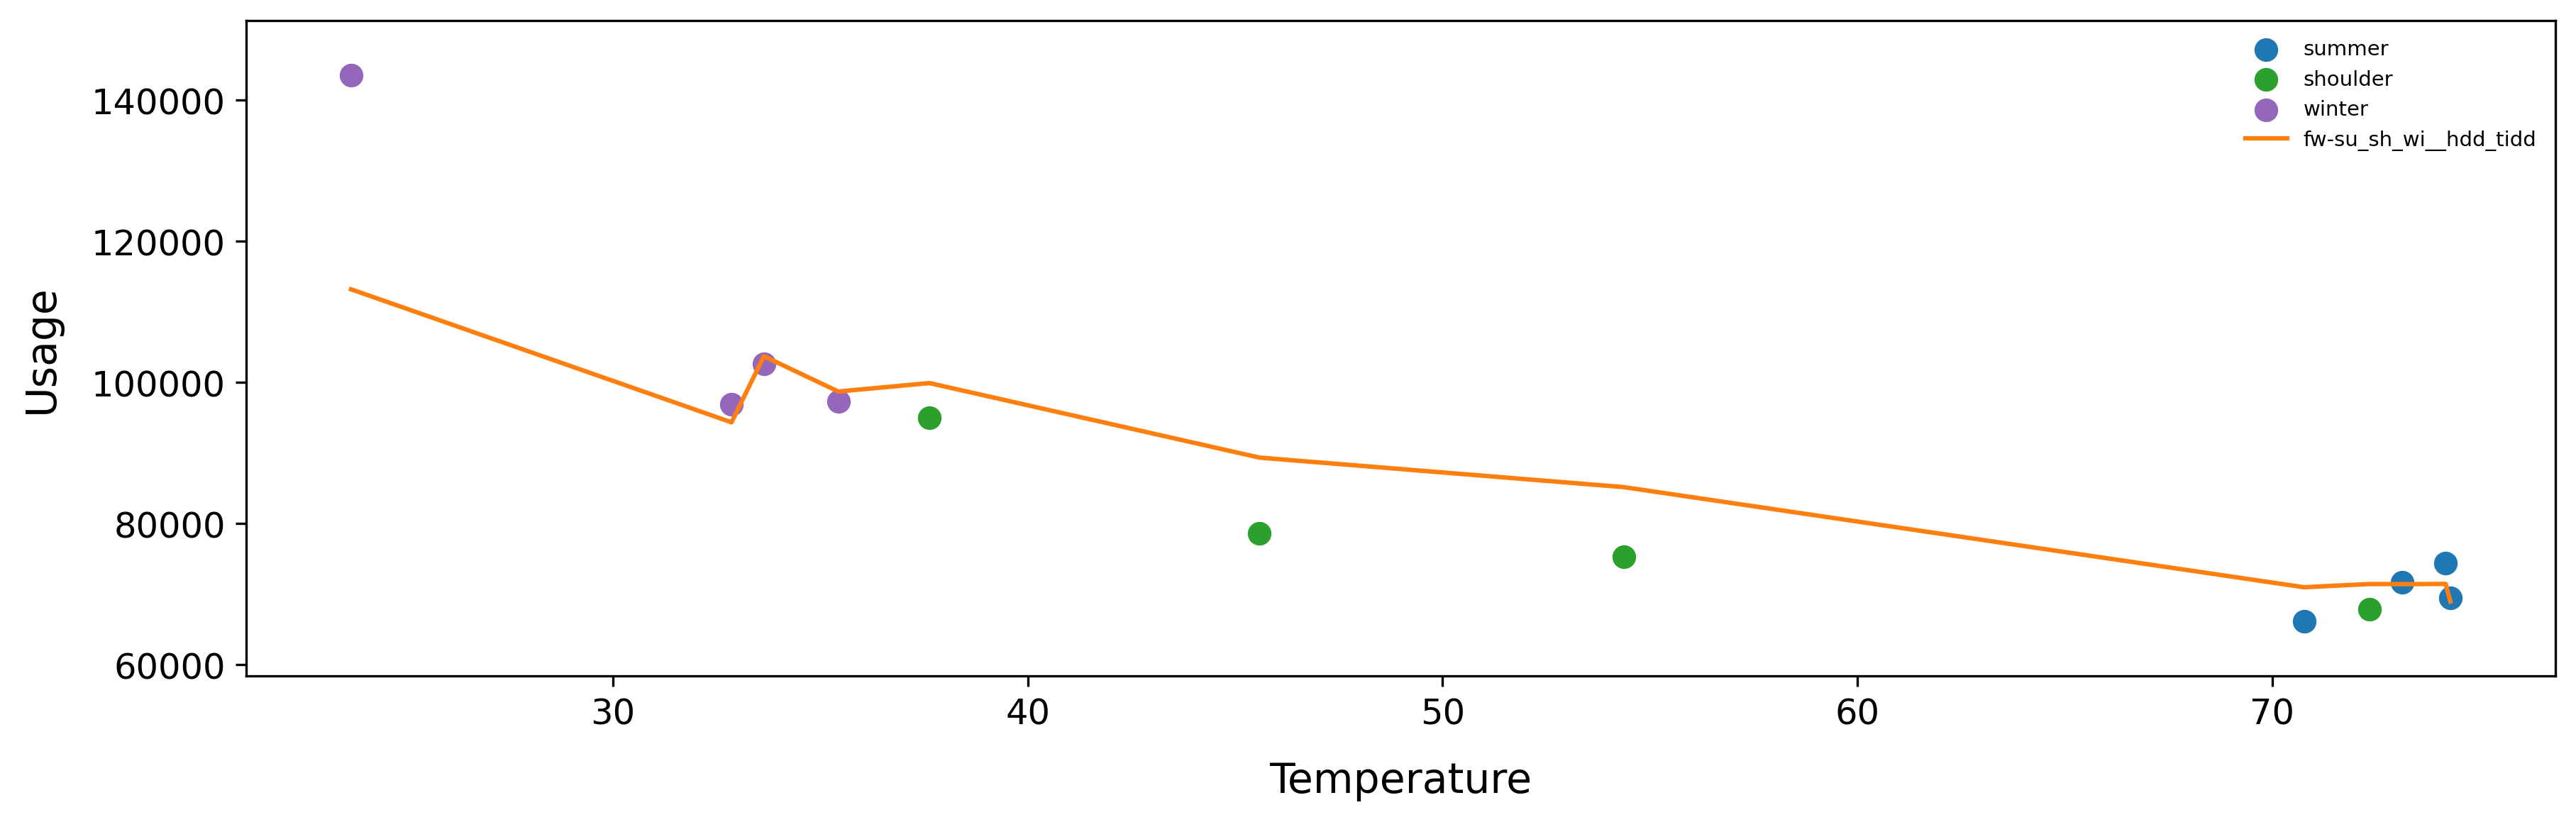

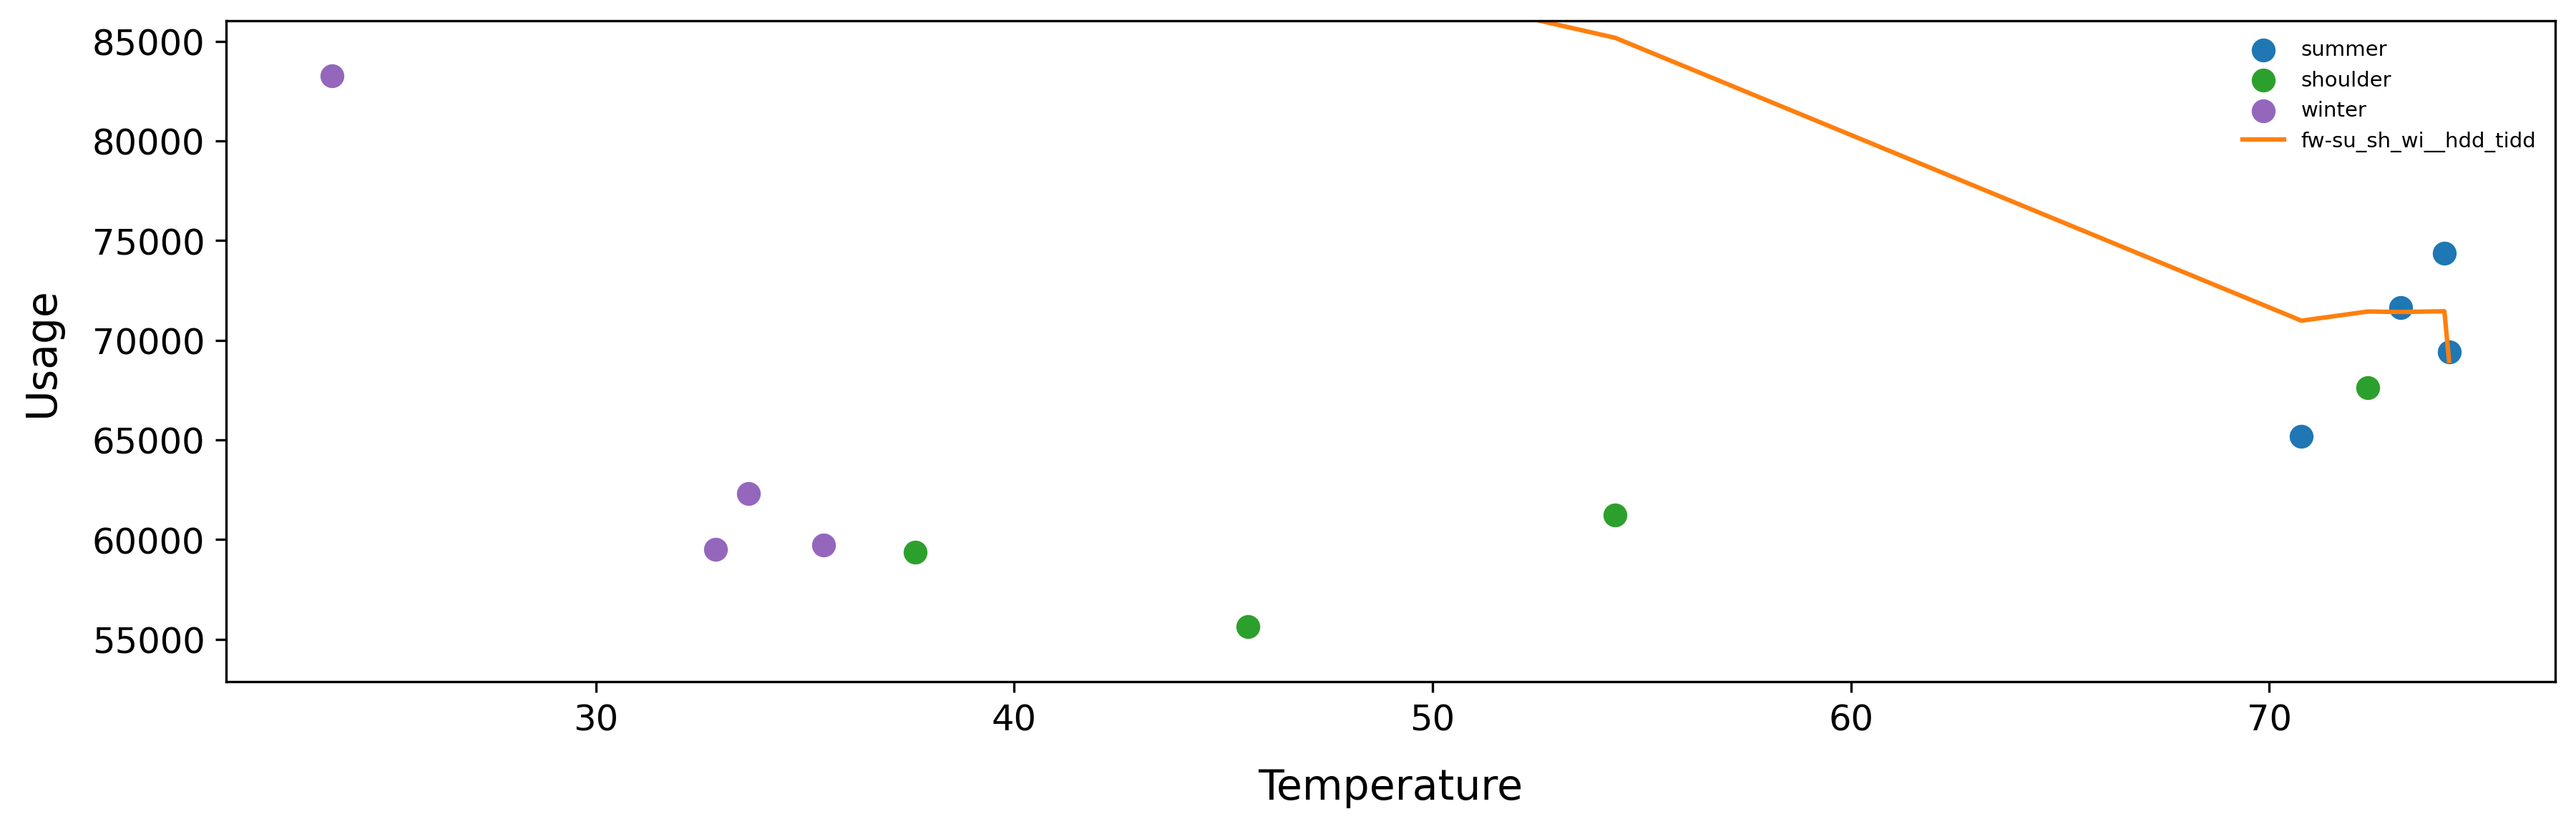

Predicted Usage (kWh):  1038677.49
Observed Usage (kWh):   789252.05
Savings (kWh):          249425.45


In [73]:
import numpy as np
import matplotlib.pyplot as plt

import opendsm as odsm
from opendsm import eemeter as em

df_baseline, df_reporting =  odsm.test_data.load_test_data("monthly_treatment_data")

n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

baseline_data = em.BillingBaselineData(df_baseline_n, is_electricity_data=True)
reporting_data = em.BillingReportingData(df_reporting_n, is_electricity_data=True)

print(f"Disqualifications: {baseline_data.disqualification}")
print(f"Warnings:          {baseline_data.warnings}")

billing_model = em.BillingModel()
billing_model.fit(baseline_data)

# Save model to json
saved_model = billing_model.to_json()
loaded_model = em.BillingModel.from_json(saved_model)

# Model results
billing_model.plot(baseline_data, aggregation="monthly")
billing_model.plot(reporting_data, aggregation="monthly")

df_results = billing_model.predict(reporting_data, aggregation="monthly")
df_results['savings'] = df_results['predicted'] - df_results['observed']
print(f"Predicted Usage (kWh):  {round(df_results['predicted'].sum(), 2)}")
print(f"Observed Usage (kWh):   {round(df_results['observed'].sum(), 2)}")
print(f"Savings (kWh):          {round(df_results['savings'].sum(), 2)}")

Similarly, the plot function also has the ability to aggregate to `monthly` or `bimonthly`. 

This model is still at its core, a modified daily model though. This is why the model prediction is not straight for either of the aggregations.

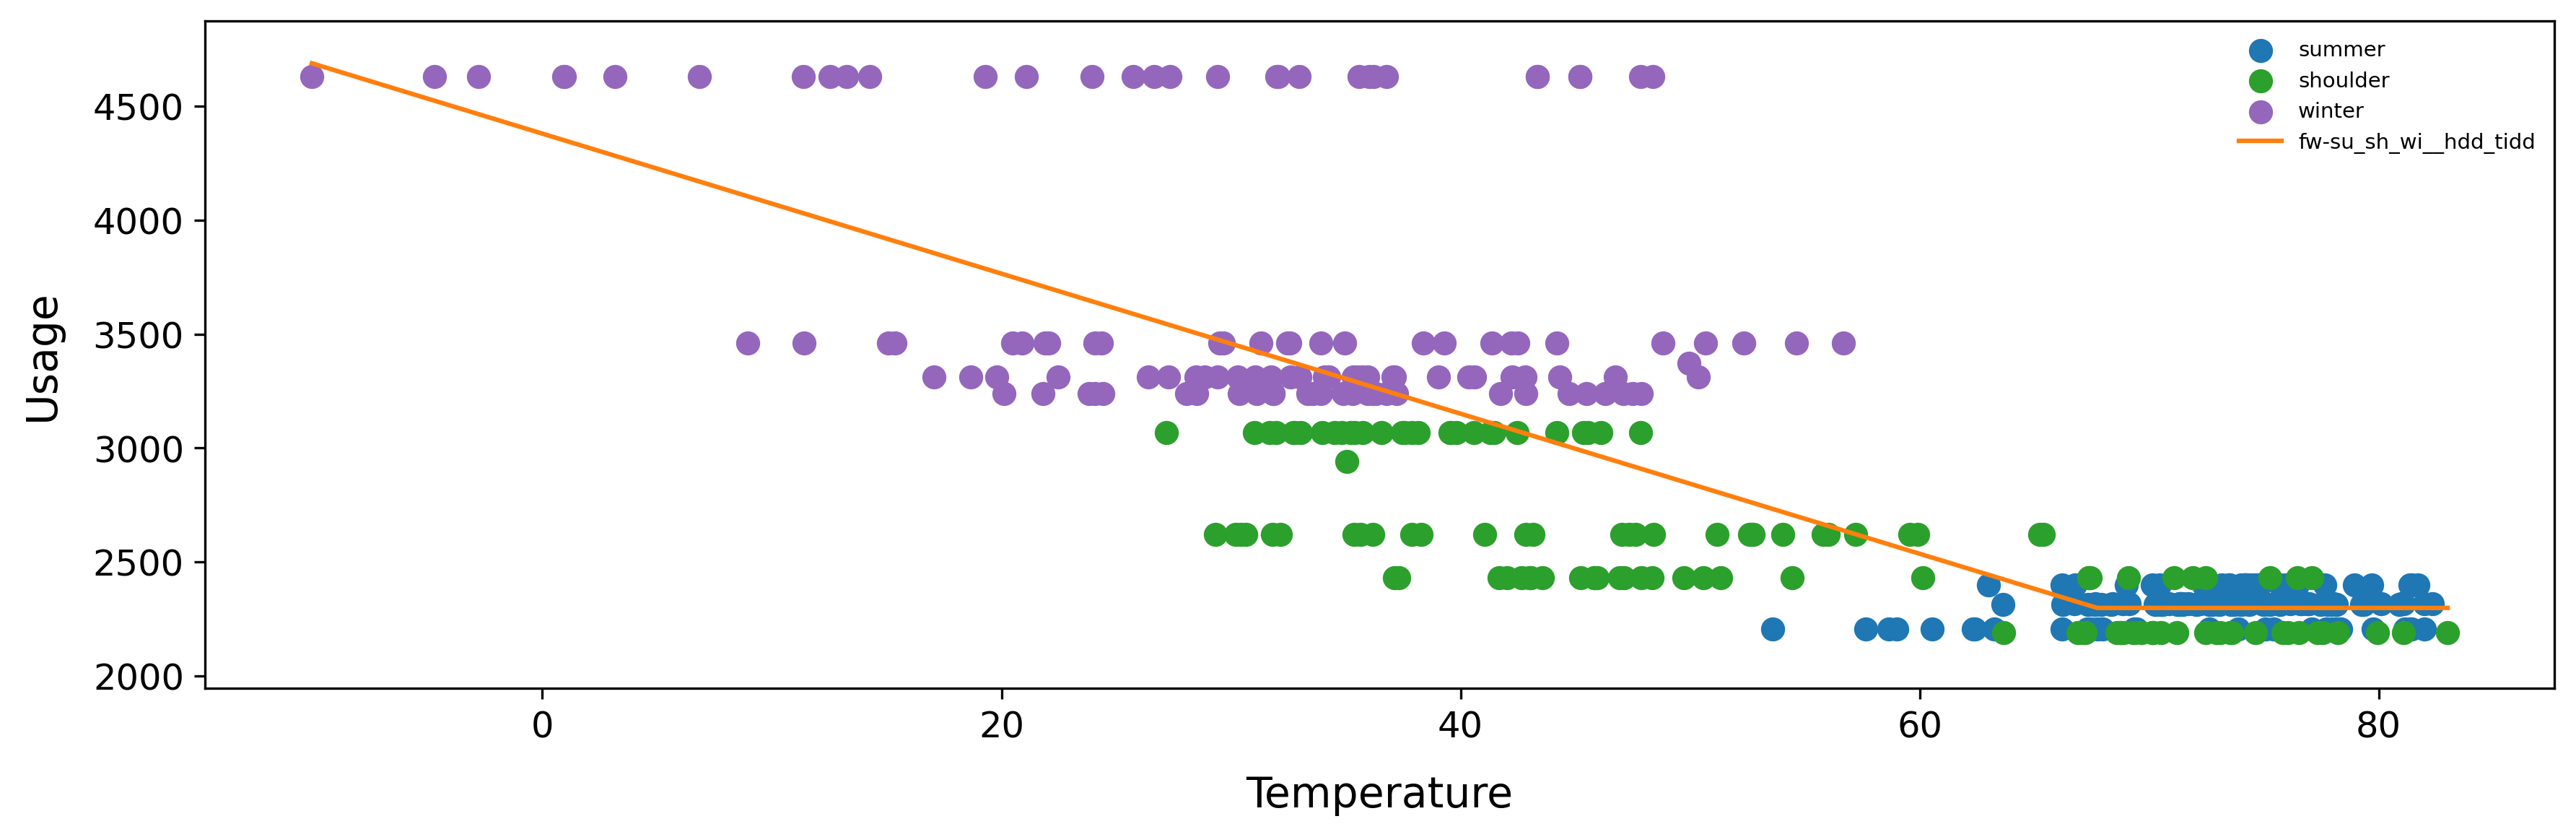

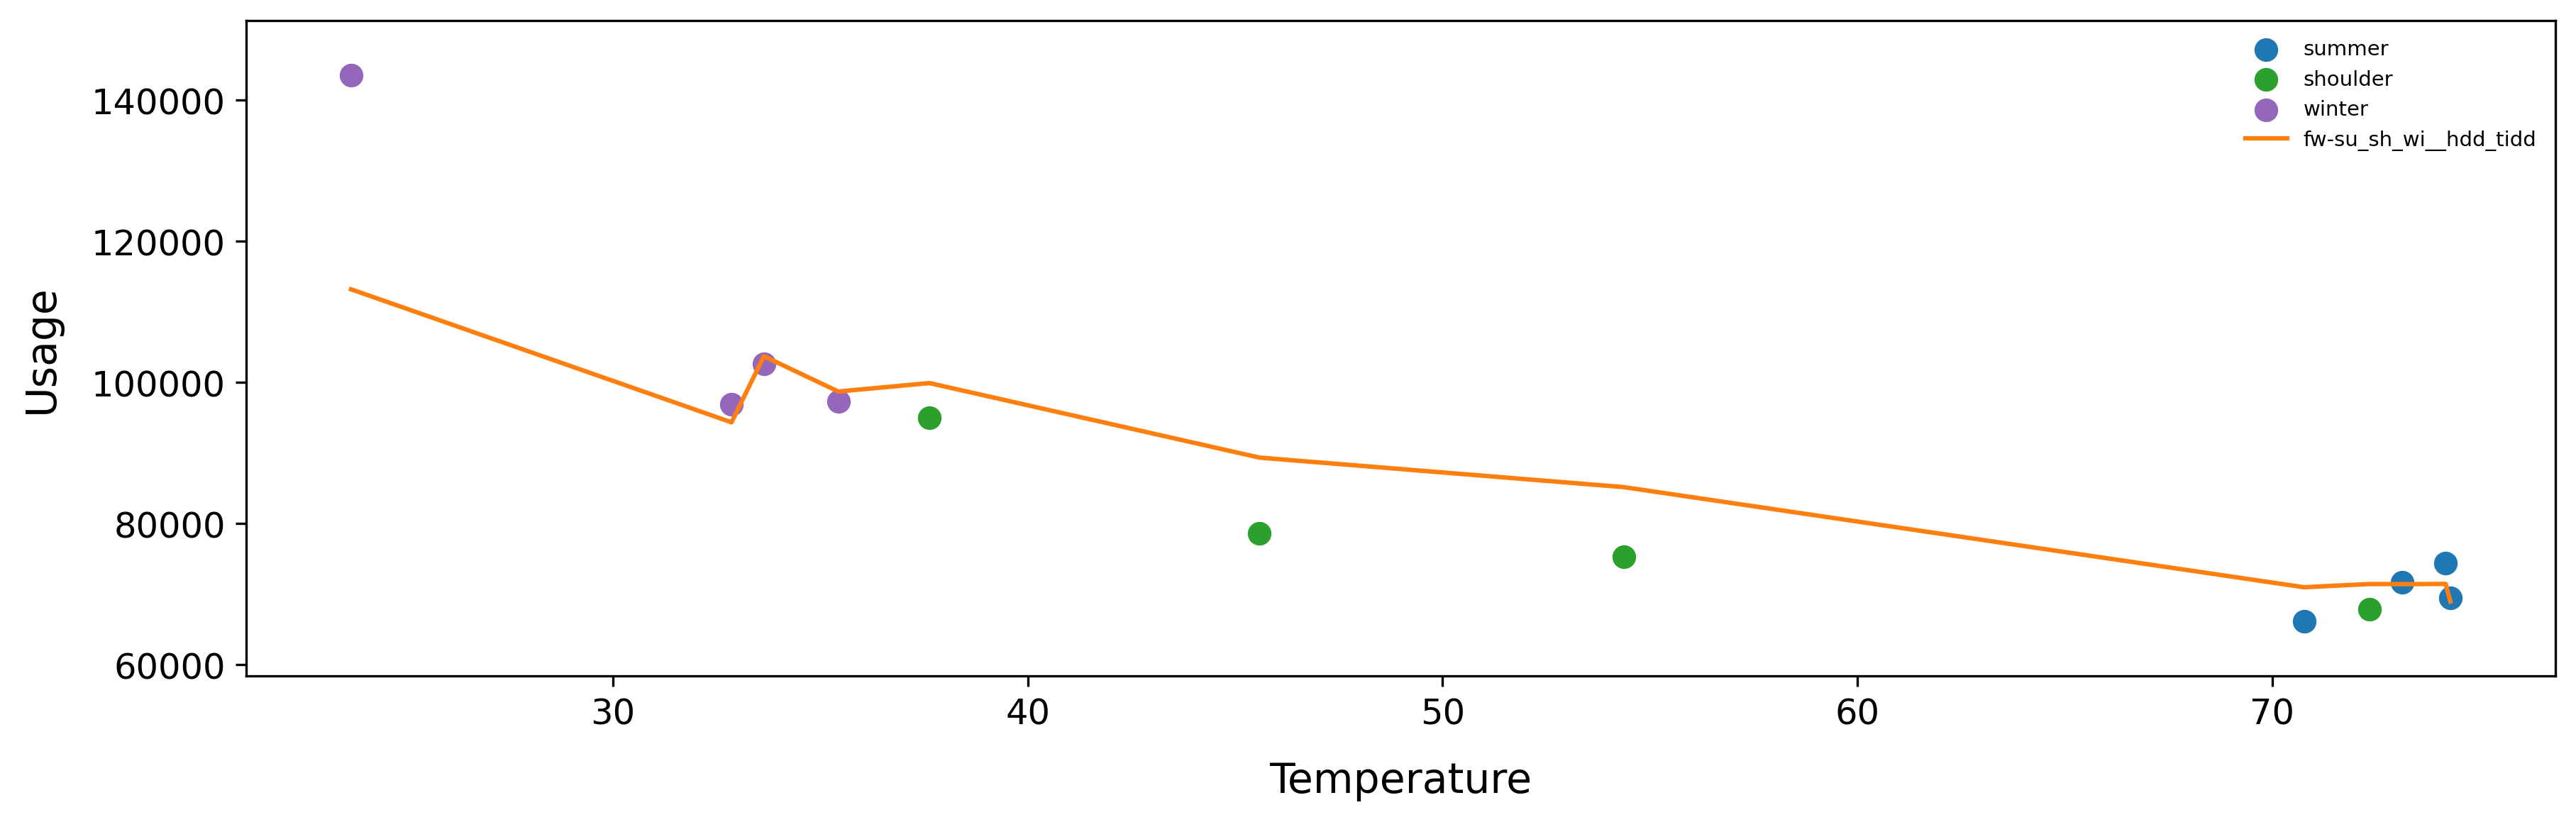

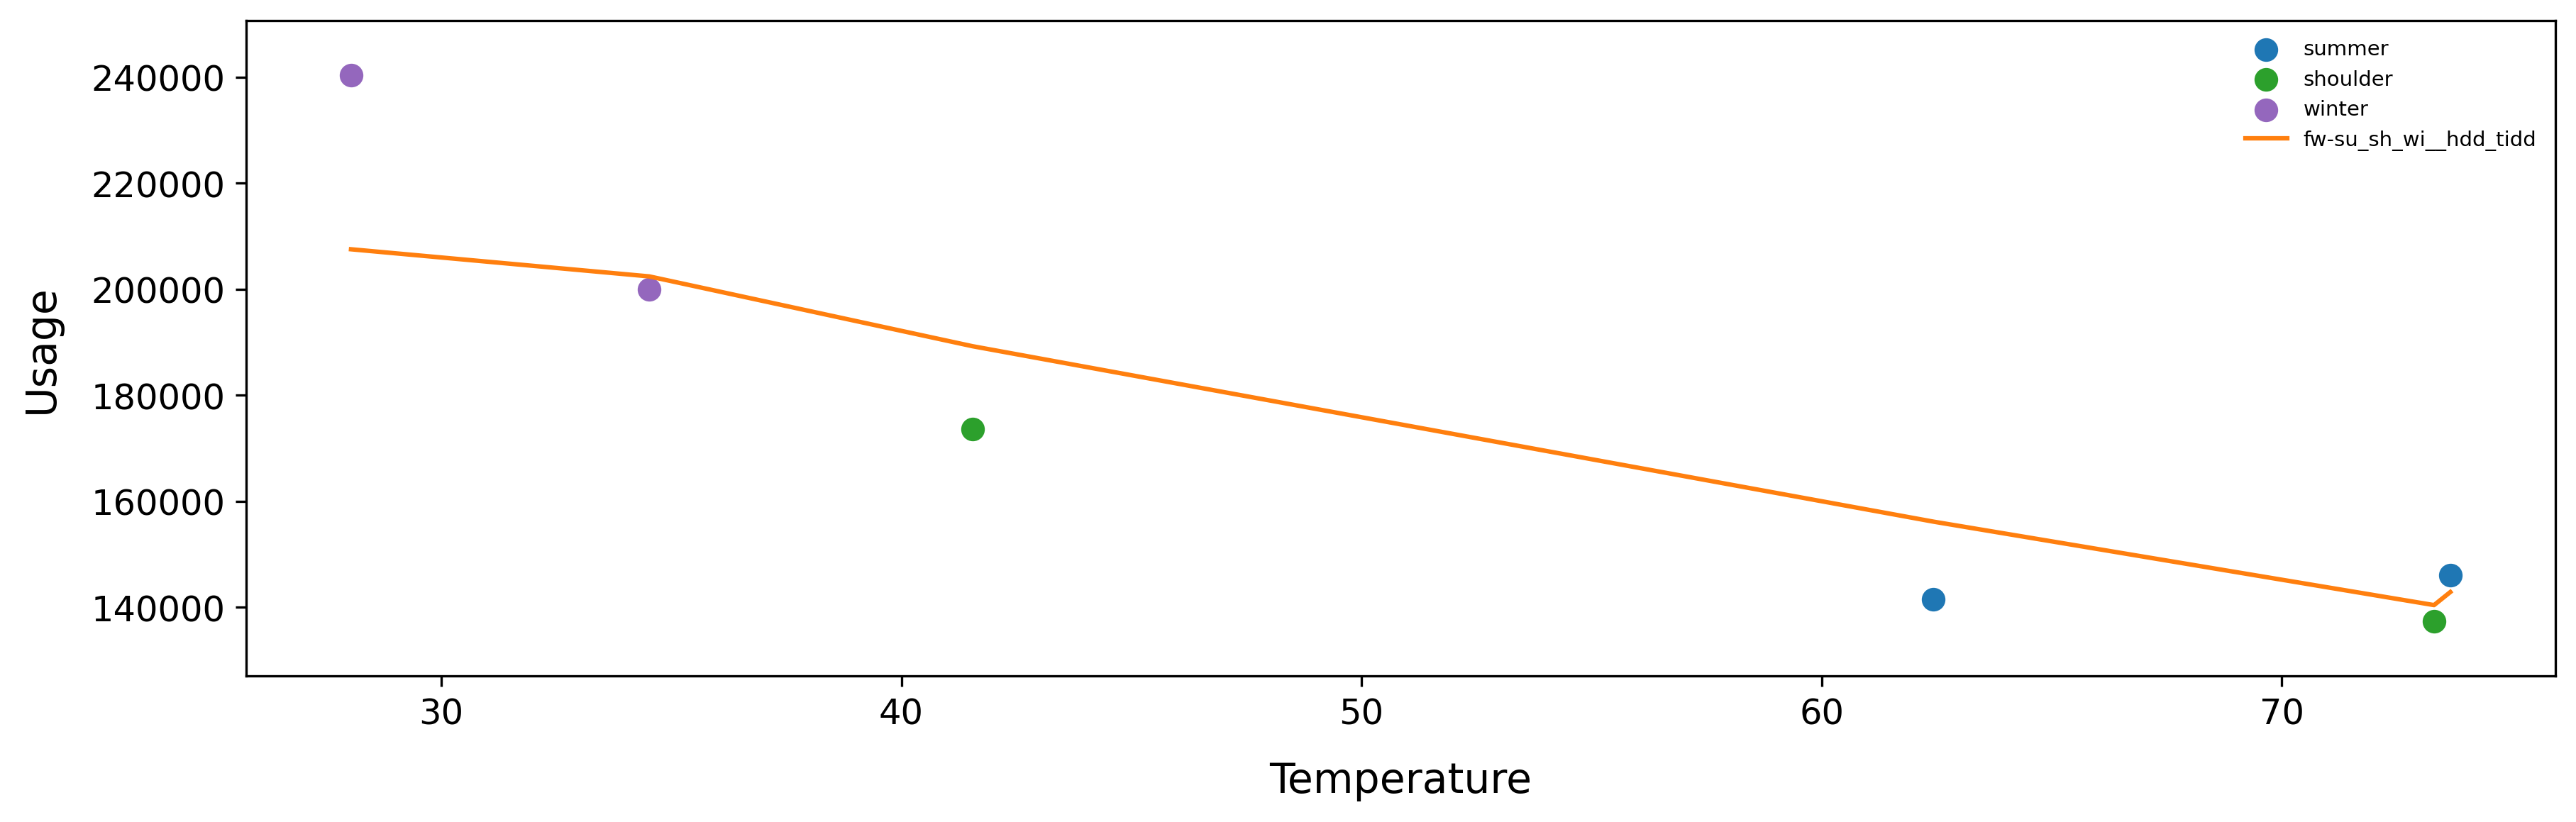

In [62]:
billing_model.plot(baseline_data)

billing_model.plot(baseline_data, aggregation="monthly")

billing_model.plot(baseline_data, aggregation="bimonthly")

## HOURLY Energy Efficiency Model

Just like the daily and billing model, we follow the same calls but for new data classes and model.

In [ ]:
df_baseline, df_reporting = odsm.test_data.load_test_data("hourly_treatment_data")

In [ ]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

hourly_baseline_data = em.HourlyBaselineData(df_baseline_n, is_electricity_data=True)
hourly_reporting_data = em.HourlyReportingData(df_reporting_n[["temperature"]], is_electricity_data=True)

hourly_model = em.HourlyModel().fit(hourly_baseline_data)

In [ ]:
hourly_model.predict(hourly_baseline_data)

## Hourly Demand Response Model

Finally, we have a demand response model meant to be used for measuring short-term demand response events within `drmeter`, but it too follows the same API structure

In [4]:
df_baseline, df_reporting = odsm.test_data.load_test_data("hourly_treatment_data")

In [6]:
n = 15

id = df_baseline.index.get_level_values(0).unique()[n]

df_baseline_n = df_baseline.loc[id]
df_reporting_n = df_reporting.loc[id]

hourly_baseline_data = dm.CaltrackDRBaselineData(df_baseline_n, is_electricity_data=True)
hourly_reporting_data = dm.CaltrackDRReportingData(df_reporting_n[["temperature"]], is_electricity_data=True)

dr_model = dm.CaltrackDRModel().fit(hourly_baseline_data)

/app/applied_data_science/opendsm/opendsm/eemeter/models/hourly_caltrack/data.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["observed"] == 0, "observed"] = np.nan


In [7]:
dr_model.predict(hourly_baseline_data)

,temperature,observed,predicted,predicted_uncertainty
datetime,,,,
2018-01-01 00:00:00-06:00,-5.08,30.336523,31.670276,29.326114
2018-01-01 01:00:00-06:00,-5.98,37.355408,32.070312,29.326114
2018-01-01 02:00:00-06:00,-7.06,39.376695,32.714753,29.326114
2018-01-01 03:00:00-06:00,-7.06,39.911217,32.758016,29.326114
2018-01-01 04:00:00-06:00,-7.06,39.406699,32.789302,29.326114
...,...,...,...,...
2018-12-31 19:00:00-06:00,33.98,15.388135,11.477984,29.326114
2018-12-31 20:00:00-06:00,33.98,15.261147,12.202178,29.326114
2018-12-31 21:00:00-06:00,33.98,13.970028,12.383450,29.326114


## How to calculate savings or avoided energy use

Savings calculation functions are not provided in `eemeter`, but to calculate basic savings is a summation of the subtraction of reporting year observed from baseline year prediction for 1 year.

- Savings = sum(predicted_baseline - observed_reporting)

In [ ]:
from PIL import Image

# Load the image
img_path = "/app/applied_data_science/opendsm/website/src/images/eemeter/daily_billing/billing_model_balance_points.png"
img = Image.open(img_path).convert("RGBA")

# Create a white background image
white_bg = Image.new("RGBA", img.size, (255, 255, 255, 255))

# Composite the original image onto the white background
composited = Image.alpha_composite(white_bg, img)

# Convert back to RGB (no alpha) and save, overwriting the original
composited.convert("RGB").save(img_path)

print(f"Image at {img_path} has been updated to have a white background.")
